In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [4]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [5]:
q1 = df['price'].quantile(0.25)
med = df['price'].quantile(0.5)
q3 = df['price'].quantile(0.75)

In [6]:
df["price_cat"] = df['price']
df.loc[df["price_cat"] < q1, "price_cat" ] = 0
df.loc[(df["price_cat"] >= q1) &  (df["price_cat"] < med), "price_cat" ] = 1
df.loc[(df["price_cat"] >= med) &  (df["price_cat"] < q3), "price_cat" ] = 2
df.loc[df["price_cat"] >= q3, "price_cat" ] = 3
df["price_cat"] = df["price_cat"].astype('int64')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_cat
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2


In [7]:
x = df.drop(["price", "id", "date", "price_cat"], axis =1)
y = df["price_cat"]
data_matrix = xgb.DMatrix(data=x.values, label=y.values)

In [8]:
params = {"objective": "multi:softprob", "num_class": 4, "max_depth": 3, "n_estimators": 100, "booster": "gbtree"}
cv_mlogloss = []
loop_range = np.arange(0.00, 1.05, 0.05)

In [9]:
%%time 
for x in loop_range:
    params["eta"] = x
    cv_scores = xgb.cv(dtrain=data_matrix, params=params, nfold=3, num_boost_round=100,
                       metrics="mlogloss", as_pandas=True, seed=123)
    cv_mlogloss.append(cv_scores["test-mlogloss-mean"].values[-1])

Wall time: 2min 10s


In [10]:
df_scores = pd.DataFrame(list(zip(np.arange(0.0, 1.05, 0.05), cv_mlogloss)), columns=["eta", "mlogloss"])
df_scores.head()

,eta,mlogloss
0,0.00,1.386303
1,0.05,0.699183
2,0.10,0.622421
3,0.15,0.589952
4,0.20,0.570498


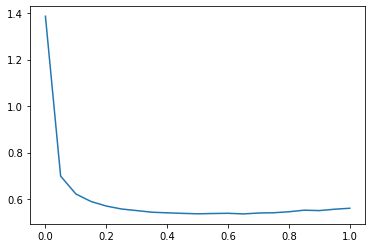

In [11]:
plt.plot(df_scores['eta'], df_scores['mlogloss'])
plt.show()

$$obj^{(t)}=\displaystyle\sum_{i=1}^{n} t_i [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega (f_t)$$

In [12]:
def plot_range(mlogloss):
    plot1 = plt.plot(df_scores['eta'], df_scores['mlogloss'] * [mlogloss])
    plt.show()

slider_widget = widgets.FloatSlider(min=0.5, max=1.5, step=0.1)
widgets.interact(plot_range, mlogloss=slider_widget)

interactive(children=(FloatSlider(value=0.5, description='mlogloss', max=1.5, min=0.5), Output()), _dom_classe…

<function __main__.plot_range(mlogloss)>

In [13]:
%%time
def plot_func(max, step):
    print("Loading...")
    cv_mlogloss_2 = []
    for x in np.arange(0.0, max, step):
        params["eta"] = x
        cv_scores = xgb.cv(dtrain=data_matrix, params=params, nfold=3, num_boost_round=100,
                           metrics="mlogloss", as_pandas=True, seed=123)
        cv_mlogloss_2.append(cv_scores["test-mlogloss-mean"].values[-1])
    df_scores_2 = pd.DataFrame(list(zip(np.arange(0.0, max, step), cv_mlogloss_2)), columns=["eta", "mlogloss"])
    df_scores_2.plot(x='eta', y='mlogloss')
    
max = widgets.IntSlider(min=1, max=10, description='max')
step = widgets.FloatSlider(min=0.25, max=1, step=0.25, description='step')

widgets.interact(plot_func, max=max, step=step)

interactive(children=(IntSlider(value=1, description='max', max=10, min=1), FloatSlider(value=0.25, descriptio…

Wall time: 27.1 s


<function __main__.plot_func(max, step)>